<a href="https://colab.research.google.com/github/Tattou20/Machine_Learning/blob/main/Ursulla_ANN_Assignment9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ursulla Navalona Arivola N01586516 - Assignment 9

#Artificial Neural Network (ANN) classifier

In [1]:
! pip install split-folders

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [6]:
transform = transforms.Compose([transforms.ToTensor()])

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
%cd /content/gdrive/MyDrive/CodeNN

/content/gdrive/MyDrive/CodeNN


###Split the folder into train and test and Prepare train and test datasets, Loaders

In [ ]:
splitfolders.ratio("HAR_Images", output="TrainTest",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 562 files [03:47,  1.01s/ files]

In [ ]:
train_data = datasets.ImageFolder('TrainTest/train', transform = transform)
test_data = datasets.ImageFolder('TrainTest/val', transform = transform)

In [ ]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 32,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Catch', 'Clap', 'Hammering']
Training images available: 3988
Testing images available:  999


## Display a batch of images

In [ ]:
for images,labels in train_loader:
    break
images.shape

torch.Size([32, 3, 227, 227])

In [ ]:
labels

tensor([1, 1, 1, 1, 2, 1, 2, 1, 1, 0, 1, 0, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 1,
        2, 0, 2, 1, 0, 2, 1, 1])

Label: [1 1 1 1 2 1 2 1 1 0 1 0 1 0 0 2 1 1 1 0 2 0 0 1 2 0 2 1 0 2 1 1]
Class: Clap Clap Clap Clap Hammering Clap Hammering Clap Clap Catch Clap Catch Clap Catch Catch Hammering Clap Clap Clap Catch Hammering Catch Catch Clap Hammering Catch Hammering Clap Catch Hammering Clap Clap


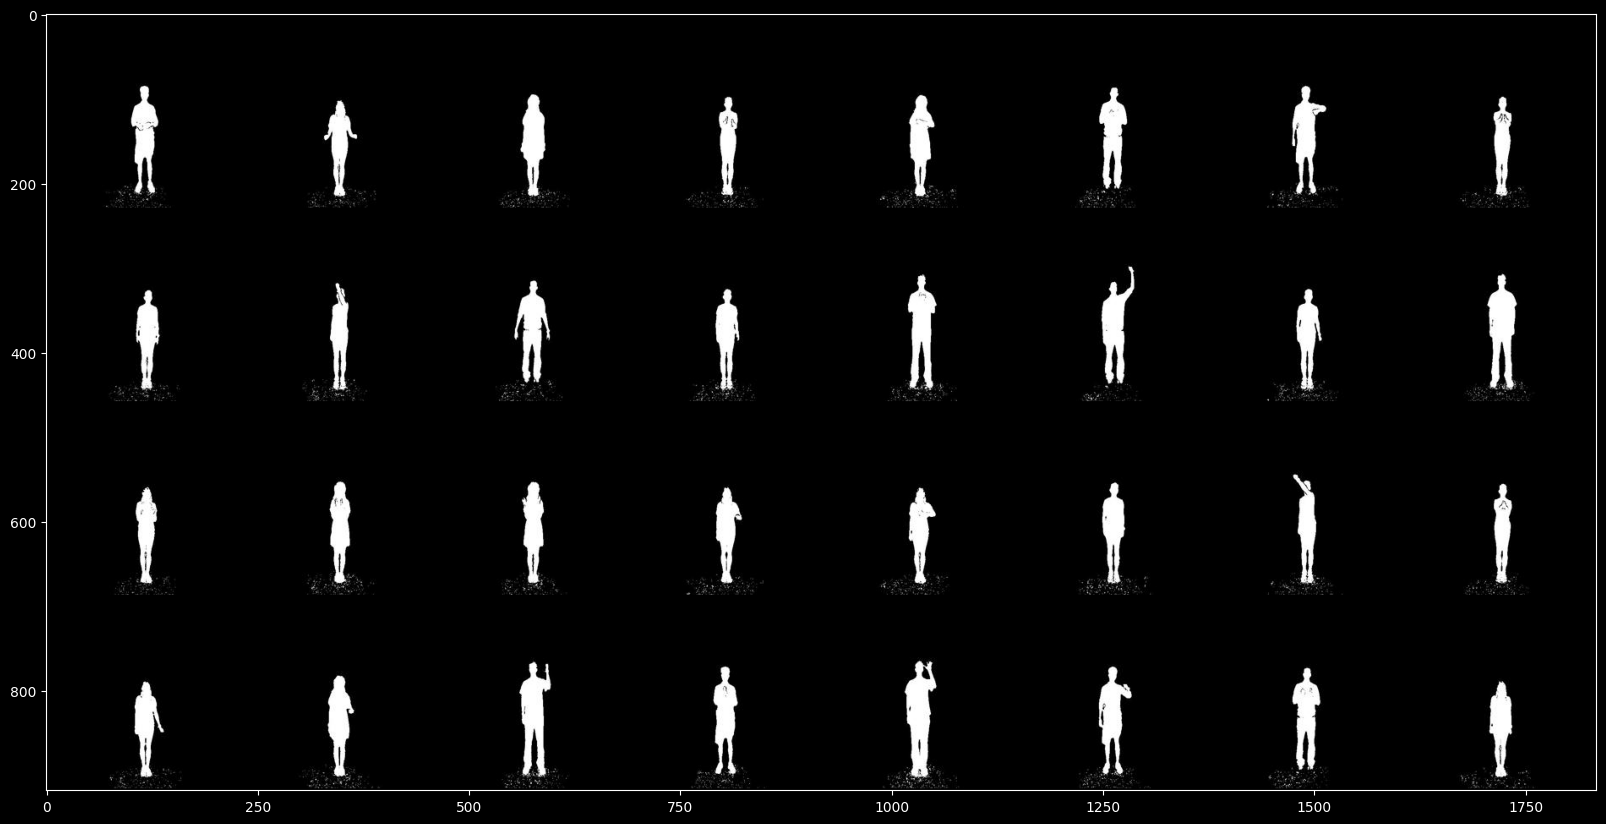

In [ ]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images)


# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

## Define the model

In [ ]:
model = nn.Sequential(
          nn.Linear(154587,21792),
          nn.ReLU(),
          nn.Linear(21792,227),
          nn.ReLU(),
          nn.Linear(32,10),
           nn.ReLU(),
          nn.Linear(227,64),
          nn.ReLU(),
          nn.Linear(64,32),
          nn.ReLU(),
          nn.Linear(32,3),
          )
model

##Train and Test the model

In [ ]:
epochs = 32
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),momentum = 0.9, lr=.001)

model.to(device)

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


for epoch in range(epochs):
 model.train()
 batchAcc  = []
 batchLoss = []
 for X,y in train_loader:
  X = X.reshape(32,3*227*227)
  X = X.to(device)
  y = y.to(device)


  ypred = model(X)
  loss = lossfun(ypred,y)


  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  batchLoss.append(loss.item())


  ypred = ypred.cpu()
  y = y.cpu()


  acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
  batchAcc.append(acc)

 trainAcc.append( np.mean(batchAcc) )

 losses[epoch] = np.mean(batchLoss)

# TESTING

 model.eval()
 X,y = next(iter(test_loader))

 X = X.to(device)
 y = y.to(device)

 with torch.no_grad():
  ypred = model(X)

  ypred = ypred.cpu()
  y = y.cpu()

  testAcc.append( 100*torch.mean((torch.argmax(ypred,dim=1)==y).float()) )
  if (epoch % 10) == 0:

        print(f' epochs : {epoch}  loss : {loss : 2.2f}')



In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()